## Racecar model

In [12]:
import matplotlib.pyplot as plt
import numpy as np

### Parameters of Car

In [6]:
sizeOfMap = 1.5
rWheel=0.05
hWheel=0.025

wheelBase = 0.325
track = 0.2

steer_angle = 0
deltaT = 1

## Work on 3d graphics

In [28]:
from pythreejs import *

In [29]:
from IPython.display import display
from ipywidgets import HTML, Text
from traitlets import link, dlink

##### Function for ploting world.

In [20]:
def getOrigin(r = 0.025, color = 'yellow', X=[0, 0, 0]):
    origin = Mesh(geometry=SphereGeometry(radius=r), 
                                          material=MeshLambertMaterial(color=color),
                                          position=X)
    return origin

def tf(rf, H):    
    
    v = H * O
    v = (np.ravel(v.getA())[0:3])
    rf.position = (v[0], v[1], v[2])
    
    
    R = H.getA()[0:3,0:3].T.ravel()
    rf.setRotationFromMatrix(R)
    
    return rf 

def getJ(length = 0.2, arrowLengthRatio = 0.1, color = 'green'):
    
    arrowLength = length * arrowLengthRatio
    lineLength = length - arrowLength

    rLine = length/150
    rArrow = length/50

    line = Mesh(geometry=CylinderGeometry(radiusTop=rLine,
                                          radiusBottom=rLine,
                                          height=lineLength), 
                                          material=MeshLambertMaterial(color=color),
                                          position=[0, lineLength/2, 0])

    arrow = Mesh(geometry=CylinderGeometry(radiusTop=0,
                                           radiusBottom=rArrow,
                                           height=arrowLength), 
                                           material=MeshLambertMaterial(color=color),
                                           position=[0, (lineLength+arrowLength)/2, 0])
    
    origin = getOrigin()
    origin.add(children=line)
    line.add(children=arrow)

    return origin

def getK(length = 0.2):
    k = getJ(length = length, color = 'blue')
    return tf(k, Rx(np.pi/2))

def getI(length = 0.2):
    k = getJ(length = length, color = 'red')
    return tf(k, Rz(-np.pi/2))

def getCoordinateFrame(length = 0.2):
    origin = getOrigin()
    ortK = getK(length = length)
    ortI = getI(length = length)
    ortJ = getJ(length = length)

    origin.add(ortK)
    origin.add(ortI)
    origin.add(ortJ)
    
    return origin

def plot3D(rf):
    scene = Scene()
    
    tf(rf, Rx(-np.pi/2))

    key_light = [DirectionalLight(color='#ffffff', intensity=0.6, position=[10,10,10])]
    ambient_light = [AmbientLight(color='#777777')]

    scene.add(rf)
    scene.add(key_light)
    scene.add(ambient_light)

    c = PerspectiveCamera(position=[2, 2, 2])
    renderer = Renderer(camera=c, background='black', background_opacity=1,
                        scene=scene, controls=[OrbitControls(controlling=c)],
                        width=800, height=800)
    display(renderer)

def rf(H):
    origin = getCoordinateFrame()
    tf(origin,H)
    return origin

##### Functions for ploting objects of the world

In [21]:
def getLine(X1,X2,color='black'):
    linegeom = Geometry(vertices=[X1,X2],colors = [color, color])
    line = Line(geometry=linegeom, 
                 material=LineBasicMaterial(linewidth=20, vertexColors='VertexColors'), 
                 type='LinePieces',
                )
    return line

def getCylinder(length, r1,r2, color):
    cylinder = Mesh(geometry=CylinderGeometry(radiusTop=r1,
                                              radiusBottom=r2,
                                              height=length), 
                                              material=MeshLambertMaterial(color=color),
                                              position=[0, 0, 0])
    return cylinder

def getGrid(size = 10):
    world = getOrigin()
    
    h=size/2
    for xi in np.arange(-h,h+1,1):
        X1 = [xi, -h, 0]
        X2 = [xi, h, 0]
        world.add(getLine(X1,X2))
    
    for yi in np.arange(-h,h+1,1):
        X1 = [-h, yi, 0]
        X2 = [ h, yi, 0]
        world.add(getLine(X1,X2))
    return world

def getWheel(r = rWheel, h = hWheel):
    wheel = Mesh(geometry=CylinderGeometry(
                                radiusTop=r,
                                radiusBottom=r,
                                height=h,
                                ), 
                               material=MeshLambertMaterial(color='black'),
                               position=[0, 0, 0])
    return wheel

def putWheel(H):
    wheel=getWheel()
    tf(wheel, H)
    return wheel


def putCylinder(length, H, r1=0.01, r2 =0.01, color = 'orange'):
    cylinder = getCylinder(length, r1, r2, color)
    tf(cylinder, H)
    return cylinder 

def putPlane(H, size = 10, color ='#e0e0e0'):
    plane = Mesh(geometry=PlaneGeometry(
                                            width=size,
                                            height=size), 
                                            material=MeshLambertMaterial(color=color),
                                            position=[0, 0, 0])
    tf(plane,H)
    return plane

##### Ackermann steering model

In [22]:
def getRadius(alpha):
    r = wheelBase/np.tan(alpha)
    return r

def getRadiusInner(alpha):
    r = getRadius(alpha)
    return (r - track/2)

def getRadiusOuter(alpha):
    r = getRadius(alpha)
    return (r + track/2)

def getSteerAngles(alpha):
    r = getRadius(alpha)
    alphaInner = np.arctan(wheelBase/(getRadiusInner(alpha)))
    alphaOuter = np.arctan(wheelBase/(getRadiusOuter(alpha)))
    
    return [alphaInner, alphaOuter]

def getWheelLine(Hwheel, r):
    X1 = Hwheel * O 
    X2 = Hwheel * Ty(r) * O
    
    X1 = (np.ravel(X1.getA())[0:3]).tolist()
    X2 = (np.ravel(X2.getA())[0:3]).tolist()

    return getLine(X1, X2, color='green')  

def getICR(H):
    point = getOrigin(r = 0.015)
    tf(point,H ) 
    return point

##### Functions for representation of robot state

In [23]:
def bicycleModel3d(x, y, theta, steerAngle):
    world = getOrigin()
    z=rWheel
    Hbaselink =  Tx(x) * Ty(y) * Tz(z) * Rz(theta)
    world.add(rf(Hbaselink))
   
    
    HbaseEnd =  Hbaselink * Tx(wheelBase) 
    world.add(tf(getOrigin(),HbaseEnd))
       
    HwheelCentralFront = HbaseEnd * Rz(steerAngle)
    world.add(rf(HwheelCentralFront))
    if (steerAngle!=0):
        r = getRadius(steerAngle)
        Hicr = Hbaselink * Ty(r)
        world.add(getICR(Hicr))
        world.add(getWheelLine(HwheelCentralFront, r/np.cos(steerAngle)))
        world.add(getWheelLine(Hbaselink, r))
        
    

    world.add(putWheel(Hbaselink))
    world.add(putWheel(HwheelCentralFront))
    
    world.add(putCylinder(r1=0.02, r2 = 0.01, length=wheelBase, H = Hbaselink*Tx(wheelBase/2)*Rz(np.pi/2)))

    return world

In [24]:
def robot3d(x, y, theta, steerAngle):
    world = getOrigin()
    z=rWheel
    Hbaselink =  Tx(x) * Ty(y) * Tz(z) * Rz(theta)
    world.add(rf(Hbaselink))
   
    
    HbaseEnd =  Hbaselink * Tx(wheelBase) 
    world.add(tf(getOrigin(),HbaseEnd))
    
    
    HwheelLeftFrontHinge = HbaseEnd * Ty(track/2)
    HwheelRightFrontHinge = HbaseEnd * Ty(-track/2)
    
    Hicr = 0
    
    if (steerAngle!=0):
        r = getRadius(steerAngle)
        Hicr = Hbaselink * Ty(r)
        world.add(getICR(Hicr))
        alphaInner, alphaOuter = getSteerAngles(steerAngle) 
        world.add(getWheelLine(Hbaselink, getRadius(steerAngle)))
        world.add(getICR(Hicr))
    else:
        alphaInner = steerAngle
        alphaOuter = steerAngle
        
    HwheelLeftFront = HwheelLeftFrontHinge * Rz(alphaInner)
    world.add(rf(HwheelLeftFront))
    ##world.add(tf(getOrigin(),HwheelLeftFront))
    
    #HwheelCentralFront = HbaseEnd * Rz(steerAngle)
    #world.add(rf(HwheelCentralFront))
    #world.add(getWheelLine(HwheelCentralFront, getRadius(steerAngle)/np.cos(steerAngle)))
    ##world.add(tf(getOrigin(),HwheelRightFront))
    
    HwheelRightFront = HwheelRightFrontHinge * Rz(alphaOuter)
    world.add(rf(HwheelRightFront))
    ##world.add(tf(getOrigin(),HwheelRightFront))
    
    if (steerAngle!=0):
        world.add(getWheelLine(HwheelLeftFront, getRadiusInner(steerAngle)/np.cos(alphaInner)))
        world.add(getWheelLine(HwheelRightFront, getRadiusOuter(steerAngle)/np.cos(alphaOuter)))
    
    
    HwheelLeftRearHinge =  Hbaselink * Ty(track/2)
   
    #world.add(HwheelLeftRearHinge)
    
    HwheelRightRearHinge =   Hbaselink *  Ty(-track/2) 
    #world.add(HwheelLeftRearHinge)
    
    HwheelLeftRear = HwheelLeftRearHinge
    ##world.add(rf(HwheelLeftRear))
    world.add(tf(getOrigin(),HwheelLeftRear)) 
        
    HwheelRightRear = HwheelRightRearHinge
    ##world.add(rf(HwheelRightRear))
    world.add(tf(getOrigin(),HwheelRightRear))
        
    world.add(putWheel(HwheelLeftFront))
    world.add(putWheel(HwheelRightFront))
    world.add(putWheel(HwheelLeftRear))
    world.add(putWheel(HwheelRightRear))
    #world.add(putWheel(HwheelCentralFront))
    
    
    world.add(putCylinder(length=track, H = Hbaselink))
    world.add(putCylinder(length=track, H = HbaseEnd))
    world.add(putCylinder(r1=0.02, r2 = 0.01, length=wheelBase, H = Hbaselink*Tx(wheelBase/2)*Rz(np.pi/2)))
    
    #plot3D(world)
    return world

## Test

In [25]:
theta = np.pi/11
steerAngle = -np.pi/4
flushWorld()
world.add(robot3d(0.3,0.5, theta,steerAngle))

NameError: name 'Mesh' is not defined

In [26]:
flushWorld()
world.add(bicycleModel3d(0.3,0.5, theta,steerAngle))

NameError: name 'Mesh' is not defined

In [18]:
plotWorld()

NameError: name 'getOrigin' is not defined

## Animation

In [30]:
def flushWorld():
    global world
    world.children = [getCoordinateFrame(length = 1),getGrid(),putPlane(Tz(-0.01))]
    
    #world.add(getOrigin(color='red', X=[1,0,0]))
    #world.add(getOrigin(color='green',X=[0,1,0]))
    #world.add(getOrigin(color='blue',X=[0,0,1]))
    
def plotWorld():
    global world
    world = getOrigin()
    
    flushWorld()
    
    scene = Scene()
    
    tf(world, Rx(-np.pi/2))

    key_light = [DirectionalLight(color='#ffffff', intensity=0.6, position=[10,10,10])]
    ambient_light = [AmbientLight(color='#777777')]

    scene.add(world)
    scene.add(key_light)
    scene.add(ambient_light)

    c = PerspectiveCamera(position=[2, 2, 2])
    renderer = Renderer(camera=c, background='black', background_opacity=1,
                        scene=scene, controls=[OrbitControls(controlling=c)],
                        width=800, height=800)
    display(renderer)

In [31]:
plotWorld()

A Jupyter Widget

## Test of Animation

In [35]:
import time

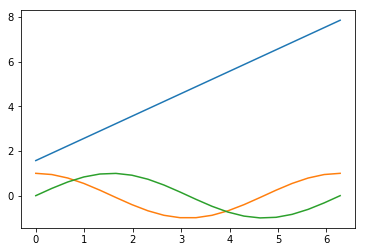

In [36]:
dt = 0.1
w = 1
N = 20
t = np.linspace(0, 2*np.pi, num = N)
steerAngle = 0.314231899 
theta = w*t + np.pi/2

r = 1

x = r*(np.cos(w*t))
y = r*(np.sin(w*t))

plt.plot(t,theta)
plt.plot(t,x)
plt.plot(t,y)
plt.show()

In [37]:
from IPython.display import clear_output

In [38]:
robots = []
for i in range(N):
    robots.append(robot3d(x[i],y[i], theta[i],steerAngle))
    clear_output()
    print(i/N)

0.95


In [39]:
flushWorld()

world.add(robots[N-1])

while True:
    world.add(robots[0])
    world.remove(robots[N-1])
    for i in range(0,N-1,1):
        world.add(robots[i+1])
        world.remove(robots[i])
        time.sleep(dt)

KeyboardInterrupt: 